In [3]:
!pip install pydub --user
!pip install speechbrain --user


You should consider upgrading via the '/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.
  Using cached ruamel.yaml-0.18.6-py3-none-any.whl (117 kB)
  Using cached torch-2.3.0-cp310-cp310-manylinux1_x86_64.whl (779.1 MB)
  Using cached ruamel.yaml.clib-0.2.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (526 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1 requires torch==1.12.0, but you have torch 2.3.0 which is incompatible.


You should consider upgrading via the '/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install sox

Defaulting to user installation because normal site-packages is not writeable
  Using cached sox-1.5.0.tar.gz (63 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sox: filename=sox-1.5.0-py3-none-any.whl size=40062 sha256=14b784721cb8f62c7e76b1c8af4af9e2fc4ecdc5e085a88fb668d71ce2a2de64
  Stored in directory: /gpfs/home6/ivbeveren/.cache/pip/wheels/74/e7/7b/8033be3ec5e4994595d01269fc9657c8fd83a0dcbf8536666a
Successfully built sox
You should consider upgrading via the '/sw/arch/RHEL8/EB_production/2022/software/Python/3.10.4-GCCcore-11.3.0/bin/python -m pip install --upgrade pip' command.


In [11]:
!sudo apt install libsox-dev


We trust you have received the usual lecture from the local System
Administrator. It usually boils down to these three things:

    #1) Respect the privacy of others.
    #2) Think before you type.
    #3) With great power comes great responsibility.

[sudo] password for ivbeveren: 
[sudo] password for ivbeveren: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!unzip drive/MyDrive/Master-thesis/UCLA.zip

Streaming output truncated to the last 5000 lines.
   creating: UCLA/034/
  inflating: UCLA/034/34A_instructions.TextGrid  
  inflating: UCLA/034/34A_instructions.wav  
  inflating: UCLA/034/34A_instructions_FAVE.TextGrid  
  inflating: UCLA/034/34A_neutral.TextGrid  
  inflating: UCLA/034/34A_neutral.wav  
  inflating: UCLA/034/34A_neutral_FAVE.TextGrid  
  inflating: UCLA/034/34A_sentences.TextGrid  
  inflating: UCLA/034/34A_sentences.wav  
  inflating: UCLA/034/34A_sentences_FAVE.TextGrid  
  inflating: UCLA/034/34A_vowels.TextGrid  
  inflating: UCLA/034/34A_vowels.wav  
  inflating: UCLA/034/34B_happy.TextGrid  
  inflating: UCLA/034/34B_happy.wav  
  inflating: UCLA/034/34B_happy_FAVE.TextGrid  
  inflating: UCLA/034/34B_phonecall.TextGrid  
  inflating: UCLA/034/34B_phonecall.wav  
  inflating: UCLA/034/34B_phonecall_FAVE.TextGrid  
  inflating: UCLA/034/34B_sentences.TextGrid  
  inflating: UCLA/034/34B_sentences.wav  
  inflating: UCLA/034/34B_sentences_FAVE.TextGrid  
  infl

In [3]:
import pandas as pd
# from speechbrain.inference.speaker import SpeakerRecognition
import os
from pydub import AudioSegment
import speechbrain
import torch
import torchaudio

/home/ivbeveren/.local/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Dataset loading ##

In [4]:
from speechbrain.dataio.dataset import DynamicItemDataset
dataset = DynamicItemDataset.from_csv("UCLA_pairs_train_small.csv") # or equivalently, DynamicItemDataset.from_csv("data.csv")

In [5]:
dataset[0]

{}

In [6]:
@speechbrain.utils.data_pipeline.takes("file1", "file2")
@speechbrain.utils.data_pipeline.provides("signal1", "signal2", "label", "file1", "file2")
def audio_pipeline(file1, file2):
#     sig1 = speechbrain.dataio.dataio.read_audio(file1)
#     sig1 = sig1.unsqueeze(0)
    sig1, sr1 = torchaudio.load(file1.replace("\\", "/"))

#     sig2 = speechbrain.dataio.dataio.read_audio(file2)
#     sig2 = sig2.unsqueeze(0)
    sig2, sr2 = torchaudio.load(file2.replace("\\", "/"))
    resampler = speechbrain.augment.time_domain.Resample(orig_freq=sr1, new_freq=16000)
    sig1 = resampler(sig1)
    sig2 = resampler(sig2)

    return sig1[0], sig2[0]

In [7]:
dataset.add_dynamic_item(audio_pipeline)
dataset.set_output_keys(["signal1", "signal2", "label", "file1", "file2"])


In [8]:
dataset[4]

{'signal1': tensor([0.0118, 0.0143, 0.0134,  ..., 0.0160, 0.0167, 0.0152]),
 'signal2': tensor([0.0134, 0.0160, 0.0150,  ..., 0.0051, 0.0059, 0.0015]),
 'label': 'True',
 'file1': 'UCLA\\007\\7A_instructions.wav',
 'file2': 'UCLA\\007\\7A_sentences.wav'}

In [9]:
str(torchaudio.get_audio_backend())

/scratch-local/ivbeveren.6601623/ipykernel_2198637/1190122611.py:1: UserWarning: torchaudio._backend.get_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  str(torchaudio.get_audio_backend())


'None'

In [11]:
from speechbrain.dataio.dataloader import SaveableDataLoader
from speechbrain.dataio.batch import PaddedBatch
dataloader = SaveableDataLoader(dataset, batch_size=2, collate_fn=PaddedBatch)

In [12]:
batch_obj = next(iter(dataloader)) # let's look at the batch obj

In [13]:
batch_obj["signal1"].data

tensor([[0.0090, 0.0109, 0.0102,  ..., 0.0115, 0.0134, 0.0052],
        [0.0047, 0.0056, 0.0068,  ..., 0.0000, 0.0000, 0.0000]])

In [14]:
lengths = batch_obj["signal1"].lengths
lengths

tensor([1.0000, 0.8180])

In [15]:
dataloader

## Some sample predictions ##

In [16]:
from speechbrain.inference.speaker import SpeakerRecognition
# verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="pretrained_models/spkrec-ecapa-voxceleb",  run_opts={"device": "cuda"})
verification = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-resnet-voxceleb", savedir="pretrained_models/spkrec-resnet-voxceleb", run_opts={"device": "cuda"})

In [17]:
score, prediction = verification.verify_files("UCLA/001/1A_instructions.wav", "UCLA/001/1B_sentences.wav") # Same Speakers


In [18]:
score

tensor(0.8242, device='cuda:0')

In [19]:
prediction

tensor(True, device='cuda:0')

In [20]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
# torch.cuda.get_device_properties(0).total_memory

'NVIDIA A100-SXM4-40GB'

In [21]:
score

tensor(0.8242, device='cuda:0')

In [22]:
prediction

tensor(True, device='cuda:0')

In [23]:
import pickle

In [24]:
outputs = []
tasks = []
for batch in iter(dataloader):
    sig1 = batch["signal1"].data
    sig2 = batch["signal2"].data

    len1 = batch["signal1"].lengths
    len2 = batch["signal2"].lengths

#     task1 = batch["task1"]
#     task2 = batch["task2"]
    try:
        score, prediction = verification.verify_batch(sig1, sig2, len1, len2)
    except:
        print("file1: " + str(batch["file1"]))
        print("file2: " + str(batch["file2"]))

        

    outputs.append((score, prediction, batch["label"]))
#     tasks.append((task1, task2))
    # print(outputs)
    # torch.cuda.empty_cache()
    # del sig1, sig2, len1, len2, score, prediction
    #     del sig1, sig2, score, prediction


    # Process the outputs as needed
    # For example, print the output

with open('test.pkl', 'wb') as f:
    pickle.dump(outputs, f)

/home/ivbeveren/.local/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [12]:
with open('Wyred.pkl', 'wb') as f:
    pickle.dump(outputs, f)

In [16]:
file = open('UCLA.pkl', 'rb')
outputs = pickle.load(file)

In [25]:
scores, X, y = zip(*outputs)

In [26]:
# X = [bool(tensor.item()) for tensor in X]
y = sum(list(y), [])
# scores = [(tensor.item()) for tensor in scores]
# scores
# t2 = [(tuple([' '.join(item[0]), ' '.join(item[1])])) for item in tasks]
# t2


In [27]:
X = [[tensor.cpu().numpy().flatten().tolist() for tensor in tensors] for tensors in X]
# Now, values_list contains a list of lists where each inner list contains the boolean values
# You can further flatten the list if you want to have a single list containing all the values
X = [value for sublist in X for value in sublist]
X = [value for sublist in X for value in sublist]
X

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [28]:
scores = [[tensor.cpu().numpy().flatten().tolist() for tensor in tensors] for tensors in scores]
# Now, values_list contains a list of lists where each inner list contains the boolean values
# You can further flatten the list if you want to have a single list containing all the values
scores = [value for sublist in scores for value in sublist]
scores = [value for sublist in scores for value in sublist]
scores

[0.7785584926605225,
 0.7484390735626221,
 0.7634117007255554,
 0.45295244455337524,
 0.9170483946800232,
 0.7445675730705261,
 0.7266960144042969,
 0.8143603205680847,
 0.8918376564979553,
 0.8762639760971069,
 0.8377379179000854,
 0.8399679660797119,
 0.6616641283035278,
 0.6789542436599731,
 0.8517535924911499,
 0.7531659007072449,
 0.8134866952896118,
 0.7176828384399414,
 0.7259416580200195,
 0.8587716221809387,
 0.8173991441726685,
 0.9105722308158875,
 0.43706125020980835,
 0.5734544992446899,
 0.8395322561264038,
 0.7607033252716064,
 0.5704509019851685,
 0.5412659645080566,
 0.7661634683609009,
 0.6637694239616394,
 0.8550313711166382,
 0.7728949785232544,
 0.5108873844146729,
 0.6809689998626709,
 0.87506103515625,
 0.8850184679031372,
 0.8140891194343567,
 0.8426735401153564,
 0.7918511033058167,
 0.7577444314956665,
 0.776098370552063,
 0.7880504131317139,
 0.7666491866111755,
 0.7842551469802856,
 0.6372947692871094,
 0.6998063325881958,
 0.7422948479652405,
 0.78824174404

In [29]:
# task1, task2 = zip(*t2)
# task1

In [30]:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False

In [31]:
y = list(map(str_to_bool, y))
y

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [48]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print(classification_report(y, X))
print(confusion_matrix(y, X))

              precision    recall  f1-score   support

       False       1.00      0.85      0.92       283
        True       0.87      1.00      0.93       290

    accuracy                           0.92       573
   macro avg       0.93      0.92      0.92       573
weighted avg       0.93      0.92      0.92       573

[[241  42]
 [  1 289]]


In [33]:
import pandas as pd
import numpy as np
import os
from operator import itemgetter
from scipy.optimize import brentq
from sklearn.metrics import roc_curve
from scipy.interpolate import interp1d

def calculate_eer(y, y_score, pos):
# y denotes groundtruth scores,
# y_score denotes the prediction scores.

    fpr, tpr, thresholds = roc_curve(y, y_score, pos_label=pos)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)

    return eer, thresh, fpr, tpr

# Creates a list of false-negative rates, a list of false-positive rates
# and a list of decision thresholds that give those error-rates.
def ComputeErrorRates(scores, labels):

    # Sort the scores from smallest to largest, and also get the corresponding
    # indexes of the sorted scores.  We will treat the sorted scores as the
    # thresholds at which the the error-rates are evaluated.
    sorted_indexes, thresholds = zip(*sorted(
        [(index, threshold) for index, threshold in enumerate(scores)],
        key=itemgetter(1)))
    sorted_labels = []
    labels = [labels[i] for i in sorted_indexes]
    fnrs = []
    fprs = []

    # At the end of this loop, fnrs[i] is the number of errors made by
    # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
    # is the total number of times that we have correctly accepted scores
    # greater than thresholds[i].
    for i in range(0, len(labels)):
        if i == 0:
            fnrs.append(labels[i])
            fprs.append(1 - labels[i])
        else:
            fnrs.append(fnrs[i-1] + labels[i])
            fprs.append(fprs[i-1] + 1 - labels[i])
    fnrs_norm = sum(labels)
    fprs_norm = len(labels) - fnrs_norm

    # Now divide by the total number of false negative errors to
    # obtain the false positive rates across all thresholds
    fnrs = [x / float(fnrs_norm) for x in fnrs]

    # Divide by the total number of corret positives to get the
    # true positive rate.  Subtract these quantities from 1 to
    # get the false positive rates.
    fprs = [1 - x / float(fprs_norm) for x in fprs]
    return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

In [34]:
eer, thresh, fpr, tpr = calculate_eer(y, scores, pos=1)
print('EER : %.2f%%'%(eer*100))

EER : 1.41%


In [35]:
c_miss = 1
c_fa = 1
p_target = 0.01

fnrs, fprs, thresholds = ComputeErrorRates(scores,
                                           y)
mindcf, threshold_default = ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa)

print("minDCF : {0:.4f}, at threshold {1:.4f} (p-target={2}, c-miss={3}, "
    "c-fa={4})".format(mindcf, threshold_default, p_target,c_miss, c_fa))

minDCF : 0.0345, at threshold 0.5297 (p-target=0.01, c-miss=1, c-fa=1)


In [29]:
def ComputeErrorRates(scores, labels):

      # Sort the scores from smallest to largest, and also get the corresponding
      # indexes of the sorted scores.  We will treat the sorted scores as the
      # thresholds at which the the error-rates are evaluated.
      sorted_indexes, thresholds = zip(*sorted(
          [(index, threshold) for index, threshold in enumerate(scores)],
          key=itemgetter(1)))
      sorted_labels = []
      labels = [labels[i] for i in sorted_indexes]
      fnrs = []
      fprs = []

      # At the end of this loop, fnrs[i] is the number of errors made by
      # incorrectly rejecting scores less than thresholds[i]. And, fprs[i]
      # is the total number of times that we have correctly accepted scores
      # greater than thresholds[i].
      for i in range(0, len(labels)):
          if i == 0:
              fnrs.append(labels[i])
              fprs.append(1 - labels[i])
          else:
              fnrs.append(fnrs[i-1] + labels[i])
              fprs.append(fprs[i-1] + 1 - labels[i])
      fnrs_norm = sum(labels)
      fprs_norm = len(labels) - fnrs_norm

      # Now divide by the total number of false negative errors to
      # obtain the false positive rates across all thresholds
      fnrs = [x / float(fnrs_norm) for x in fnrs]

      # Divide by the total number of corret positives to get the
      # true positive rate.  Subtract these quantities from 1 to
      # get the false positive rates.
      fprs = [1 - x / float(fprs_norm) for x in fprs]
      return fnrs, fprs, thresholds

# Computes the minimum of the detection cost function.  The comments refer to
# equations in Section 3 of the NIST 2016 Speaker Recognition Evaluation Plan.
def ComputeMinDcf(fnrs, fprs, thresholds, p_target, c_miss, c_fa):
    min_c_det = float("inf")
    min_c_det_threshold = thresholds[0]
    for i in range(0, len(fnrs)):
        # See Equation (2).  it is a weighted sum of false negative
        # and false positive errors.
        c_det = c_miss * fnrs[i] * p_target + c_fa * fprs[i] * (1 - p_target)
        if c_det < min_c_det:
            min_c_det = c_det
            min_c_det_threshold = thresholds[i]
    # See Equations (3) and (4).  Now we normalize the cost.
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, min_c_det_threshold

In [30]:
fnrs, fprs, thresholds = ComputeErrorRates(scores, labels)
mindcf, threshold = ComputeMinDcf(fnrs, fprs, thresholds, p_target,
         c_miss, c_fa)
print(mindcf, threshold)

NameError: name 'labels' is not defined

In [ ]:
df = pd.DataFrame({'Score': scores, 'pred': X, 'truth': y, 'task1': task1, 'task2': task2})
df

,Score,pred,truth,task1,task2
0,0.890022,True,True,neutral,happy
1,0.903219,True,True,instructions,annoyed
2,0.790412,True,True,sentences,phonecall
3,0.613434,True,True,happy,video
4,0.834203,True,True,neutral,phonecall
...,...,...,...,...,...
578,0.148296,False,False,phonecall,annoyed
579,0.127593,False,False,happy,sentences
580,0.000481,False,False,sentences,instructions
581,0.179639,False,False,annoyed,sentences


In [ ]:
df['verdict'] = df['truth'] == df['pred']
misses = df[df['verdict'] == False]
c1 = misses['task1'].value_counts()
c2 = misses['task2'].value_counts()

c1.add(c2, fill_value=0)

annoyed          9
happy           13
instructions    13
neutral         10
phonecall        8
sentences       53
video           18
Name: count, dtype: int64

In [ ]:
misses

,Score,pred,truth,task1,task2,verdict
154,0.082095,False,True,instructions,video,False
283,0.313338,True,False,phonecall,phonecall,False
287,0.254804,True,False,instructions,sentences,False
288,0.353219,True,False,sentences,instructions,False
301,0.253845,True,False,sentences,sentences,False
...,...,...,...,...,...,...
550,0.364113,True,False,phonecall,video,False
551,0.363437,True,False,sentences,neutral,False
556,0.347219,True,False,phonecall,sentences,False
557,0.258612,True,False,video,video,False


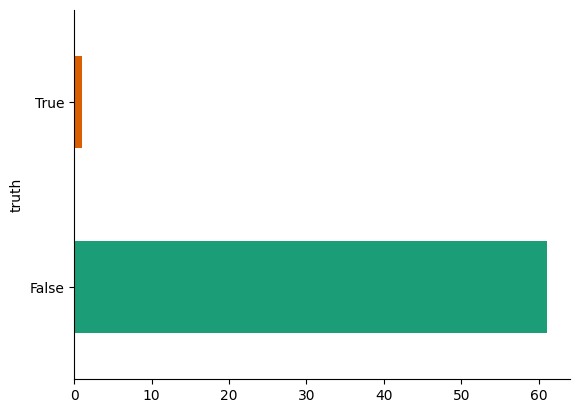

In [ ]:
# @title truth

from matplotlib import pyplot as plt
import seaborn as sns
misses.groupby('truth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

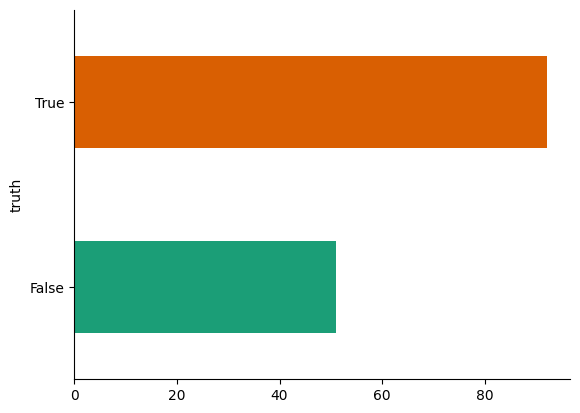

In [ ]:
# @title truth

from matplotlib import pyplot as plt
import seaborn as sns
misses.groupby('truth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

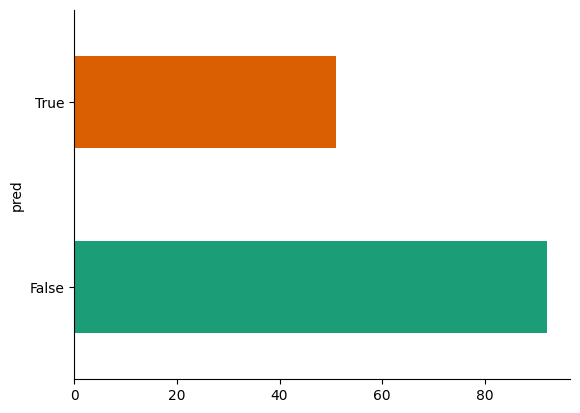

In [ ]:
# @title pred

from matplotlib import pyplot as plt
import seaborn as sns
misses.groupby('pred').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)